In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.0 MB/s eta 0:00:00


In [76]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import classification_report
import keras
from keras.models import Model
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [77]:
path = "/content/drive/MyDrive/paru/data"
# Ukuran gambar sesuai dengan input VGG19
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Penyesuaian batch size
BATCH_SIZE = 64

# Pengaturan generator gambar dengan rescale untuk val dan test
datagen_val_test = ImageDataGenerator(rescale=1.0 / 255)

traindata = ImageDataGenerator().flow_from_directory(
    path+'/train',
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

testdata = ImageDataGenerator().flow_from_directory(
    path+"/test",
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = ImageDataGenerator().flow_from_directory(
    path+"/valid",
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Melihat urutan kelas yang digunakan
class_indices = traindata.class_indices
print(class_indices)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
{'adenocarcinoma': 0, 'large cell carcinoma': 1, 'normal': 2, 'squamous cell carcinoma': 3}


In [78]:
vgg19model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [79]:
vgg19model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [80]:
#base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layers in (vgg19model.layers)[:22]:
    layers.trainable = False

In [81]:
X = Flatten()(vgg19model.output)
X = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(X)
X = Dropout(0.5)(X)
X = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(X)
X = Dropout(0.5)(X)
predictions = Dense(4, activation='softmax')(X)
#output = Dense(num_classes, activation='softmax')(x)

In [82]:
model_final = Model(inputs=vgg19model.input, outputs=predictions)

In [83]:
model_final.compile(
    loss='categorical_crossentropy',  # Menggunakan 'categorical_crossentropy' untuk klasifikasi multi-kelas
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Menggunakan optimizer Adam dengan learning rate yang lebih tinggi
    metrics=['accuracy']
)



In [84]:
model_final.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [85]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
#datagen.fit(x_train)


In [86]:
checkpoint = ModelCheckpoint(
    path + "/VGG19_model_best.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False
)
early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=5,  # Memberikan kesabaran lebih untuk menghentikan pelatihan
    verbose=1,
    mode='auto'
)


In [87]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)


In [88]:
hist = model_final.fit(
    traindata,
    epochs=30,
    validation_data=val_data,
    steps_per_epoch=traindata.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE,
    callbacks=[checkpoint, early]
)

  # Example code with correct indentation
model_final.save(path + "/VGG19_model_final.h5")


Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 14.6844 - accuracy: 0.3352
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/paru/data/VGG19_model_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 10s 850ms/step - loss: 14.6844 - accuracy: 0.3352 - val_loss: 4.4958 - val_accuracy: 0.5000
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 7.5757 - accuracy: 0.4718
Epoch 2: val_accuracy improved from 0.50000 to 0.62500, saving model to /content/drive/MyDrive/paru/data/VGG19_model_best.h5
9/9 [==============================] - 9s 897ms/step - loss: 7.5757 - accuracy: 0.4718 - val_loss: 2.5176 - val_accuracy: 0.6250
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 4.8766 - accuracy: 0.5719
Epoch 3: val_accuracy did not improve from 0.62500
9/9 [==============================] - 7s 650ms/step - loss: 4.8766 - accuracy: 0.5719 - val_loss: 2.4860 - val_accuracy: 0.6250
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 3.6262 - accuracy: 0.6393
Epoch 4: val_accuracy improved from 0.62500 to 0.65625, saving model to /content/drive/MyDrive/paru/data/VGG19_model_best.h5
9/9 [=============================

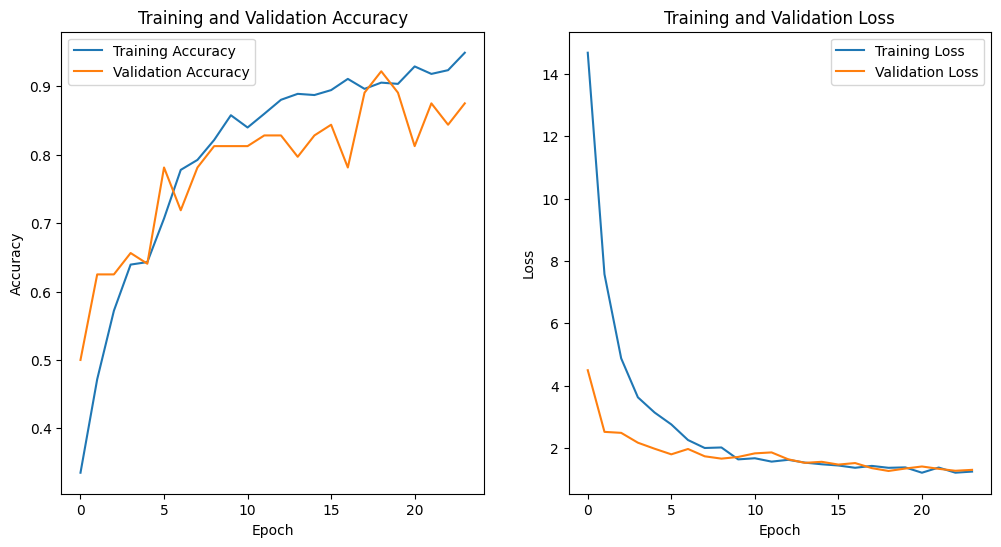

In [89]:
# Plotting training and validation accuracy and loss
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


2/2 [==============================] - 1s 340ms/step
                         precision    recall  f1-score   support

         adenocarcinoma       0.91      0.87      0.89        23
   large cell carcinoma       0.95      0.90      0.93        21
                 normal       1.00      1.00      1.00        13
squamous cell carcinoma       0.76      0.87      0.81        15

               accuracy                           0.90        72
              macro avg       0.91      0.91      0.91        72
           weighted avg       0.91      0.90      0.90        72



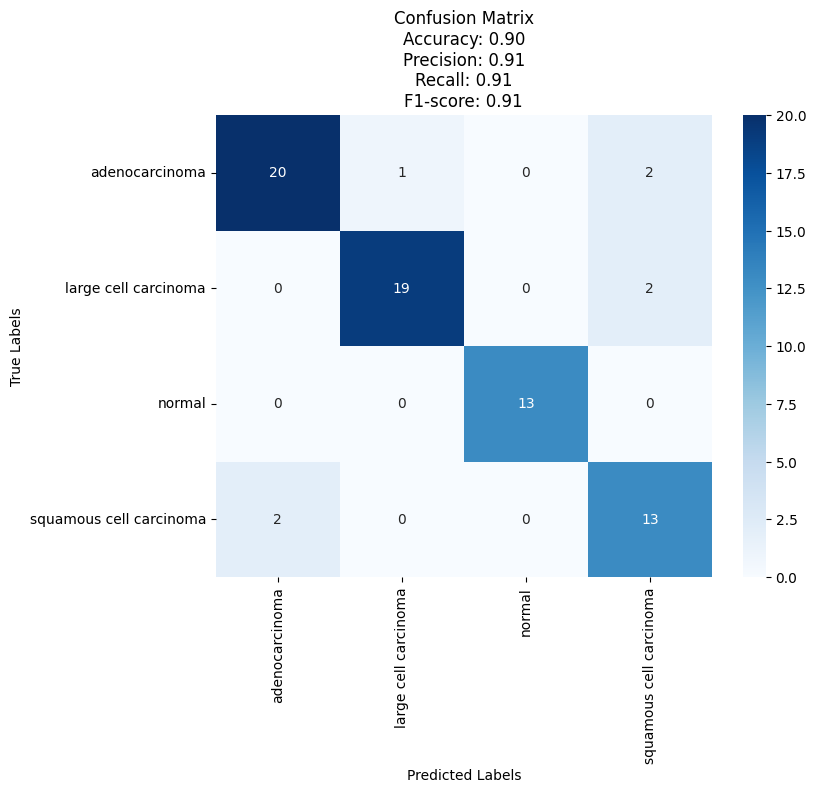

In [90]:
from sklearn.metrics import classification_report
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
best_model_path = path + '/VGG19_model_best.h5'
model_final = load_model(best_model_path)

# Evaluate model using validation data
pred = model_final.predict(val_data)

# Convert predictions to class labels
predictions = np.argmax(pred, axis=-1)

# Display classification report
print(classification_report(val_data.classes, predictions, target_names=list(val_data.class_indices.keys())))

# Compute confusion matrix
cm = confusion_matrix(val_data.classes, predictions)

# Retrieve class labels
class_labels = list(val_data.class_indices.keys())

# Compute classification report
report = classification_report(val_data.classes, predictions, target_names=class_labels, output_dict=True)

# Extract metrics
accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix\nAccuracy: {:.2f}\nPrecision: {:.2f}\nRecall: {:.2f}\nF1-score: {:.2f}'.format(accuracy, precision, recall, f1_score))
plt.show()

codingan buat sendiri sesuai codingan diatas

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 159ms/step


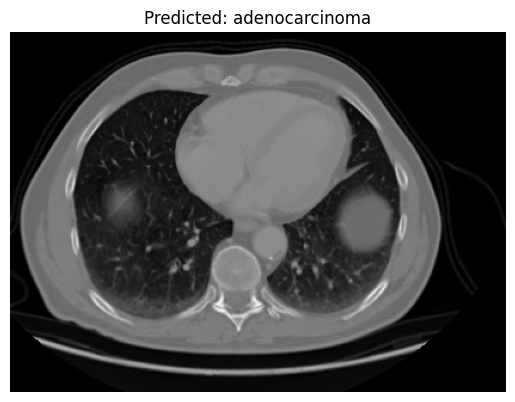

The predicted class for the image is: adenocarcinoma


In [112]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')

# Path ke model yang sudah dilatih
best_model_path = '/content/drive/MyDrive/paru/data/VGG19_model_best.h5'
model_final = load_model(best_model_path)

# Fungsi untuk memuat dan memprediksi kelas gambar
def predict_image_class(img_path):
    # Muat gambar
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Konversi gambar ke array numpy
    img_array = image.img_to_array(img)

    # Tambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar
    img_array /= 255.0

    # Prediksi kelas gambar
    prediction = model_final.predict(img_array)

    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(prediction, axis=-1)[0]

    # Dapatkan label kelas yang diprediksi
    class_labels = list(val_data.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    # Visualisasi gambar dan prediksi
    plt.imshow(image.load_img(img_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Contoh penggunaan fungsi untuk memprediksi gambar baru
img_path = '/content/drive/MyDrive/paru/data/test/adenocarcinoma/000123 (4).png'  # Ganti dengan path gambar yang ingin diprediksi
predicted_label = predict_image_class(img_path)
print(f'The predicted class for the image is: {predicted_label}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 310ms/step


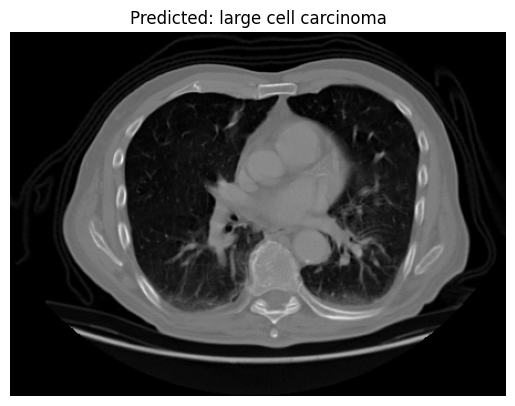

The predicted class for the image is: large cell carcinoma


In [111]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')

# Path ke model yang sudah dilatih
best_model_path = '/content/drive/MyDrive/paru/data/VGG19_model_best.h5'
model_final = load_model(best_model_path)

# Fungsi untuk memuat dan memprediksi kelas gambar
def predict_image_class(img_path):
    # Muat gambar
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Konversi gambar ke array numpy
    img_array = image.img_to_array(img)

    # Tambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar
    img_array /= 255.0

    # Prediksi kelas gambar
    prediction = model_final.predict(img_array)

    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(prediction, axis=-1)[0]

    # Dapatkan label kelas yang diprediksi
    class_labels = list(val_data.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    # Visualisasi gambar dan prediksi
    plt.imshow(image.load_img(img_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Contoh penggunaan fungsi untuk memprediksi gambar baru
img_path = '/content/drive/MyDrive/paru/data/test/large.cell.carcinoma/000116.png'  # Ganti dengan path gambar yang ingin diprediksi
predicted_label = predict_image_class(img_path)
print(f'The predicted class for the image is: {predicted_label}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 262ms/step


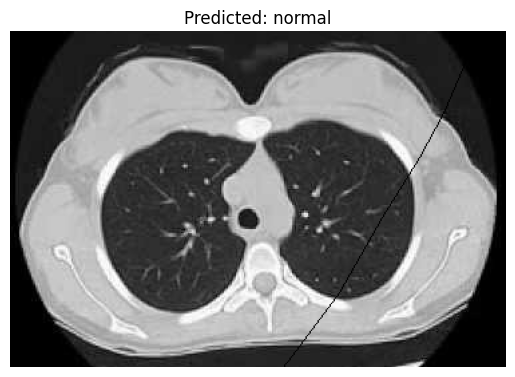

The predicted class for the image is: normal


In [110]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')

# Path ke model yang sudah dilatih
best_model_path = '/content/drive/MyDrive/paru/data/VGG19_model_best.h5'
model_final = load_model(best_model_path)

# Fungsi untuk memuat dan memprediksi kelas gambar
def predict_image_class(img_path):
    # Muat gambar
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Konversi gambar ke array numpy
    img_array = image.img_to_array(img)

    # Tambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar
    img_array /= 255.0

    # Prediksi kelas gambar
    prediction = model_final.predict(img_array)

    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(prediction, axis=-1)[0]

    # Dapatkan label kelas yang diprediksi
    class_labels = list(val_data.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    # Visualisasi gambar dan prediksi
    plt.imshow(image.load_img(img_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Contoh penggunaan fungsi untuk memprediksi gambar baru
img_path = '/content/drive/MyDrive/paru/data/test/normal/10 (2) - Copy.png'  # Ganti dengan path gambar yang ingin diprediksi
predicted_label = predict_image_class(img_path)
print(f'The predicted class for the image is: {predicted_label}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 160ms/step


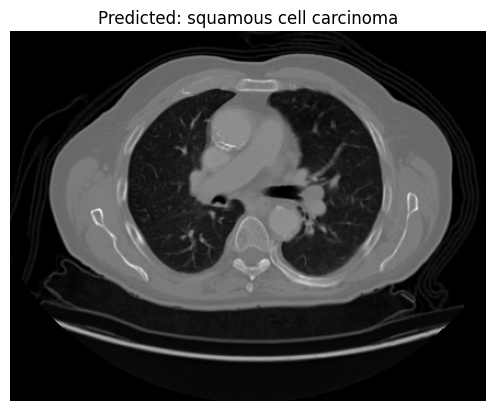

The predicted class for the image is: squamous cell carcinoma


In [109]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')

# Path ke model yang sudah dilatih
best_model_path = '/content/drive/MyDrive/paru/data/VGG19_model_best.h5'
model_final = load_model(best_model_path)

# Fungsi untuk memuat dan memprediksi kelas gambar
def predict_image_class(img_path):
    # Muat gambar
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Konversi gambar ke array numpy
    img_array = image.img_to_array(img)

    # Tambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisasi gambar
    img_array /= 255.0

    # Prediksi kelas gambar
    prediction = model_final.predict(img_array)

    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(prediction, axis=-1)[0]

    # Dapatkan label kelas yang diprediksi
    class_labels = list(val_data.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    # Visualisasi gambar dan prediksi
    plt.imshow(image.load_img(img_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Contoh penggunaan fungsi untuk memprediksi gambar baru
img_path = '/content/drive/MyDrive/paru/data/test/squamous.cell.carcinoma/000112.png'  # Ganti dengan path gambar yang ingin diprediksi
predicted_label = predict_image_class(img_path)
print(f'The predicted class for the image is: {predicted_label}')


codingan dari cica adeno-normal semua gambar terbaca dengan benar, squamous gambar itu saja

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 167ms/step


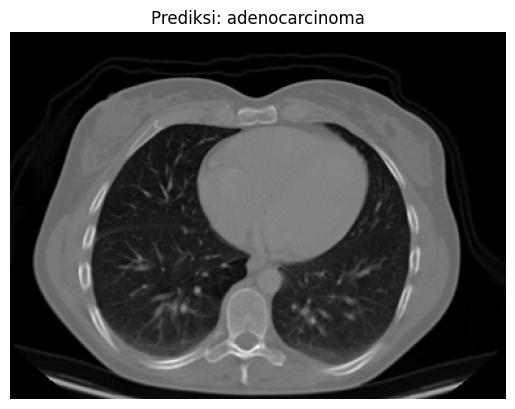

Gambar diklasifikasikan sebagai: adenocarcinoma


In [115]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from google.colab import drive

# Mount Google Drive untuk mengakses file model
drive.mount('/content/drive')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/paru/data/VGG19_model_best.h5"

# Muat model yang sudah dilatih
model = load_model(model_path)

# Fungsi untuk memproses gambar
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Daftar label kelas
class_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(img_path):
    img_array = prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Path ke gambar yang akan diuji
image_path = "/content/drive/MyDrive/paru/data/test/adenocarcinoma/000108 (3).png"

# Prediksi kelas gambar
predicted_label = predict_image_class(image_path)
print(f'Gambar diklasifikasikan sebagai: {predicted_label}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 265ms/step


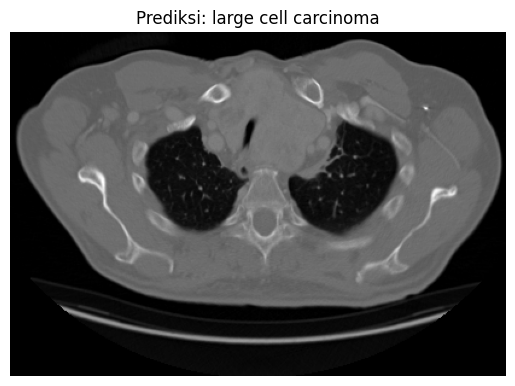

Gambar diklasifikasikan sebagai: large cell carcinoma


In [116]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from google.colab import drive

# Mount Google Drive untuk mengakses file model
drive.mount('/content/drive')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/paru/data/VGG19_model_best.h5"

# Muat model yang sudah dilatih
model = load_model(model_path)

# Fungsi untuk memproses gambar
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Daftar label kelas
class_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(img_path):
    img_array = prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Path ke gambar yang akan diuji
image_path = "/content/drive/MyDrive/paru/data/test/large.cell.carcinoma/000108.png"

# Prediksi kelas gambar
predicted_label = predict_image_class(image_path)
print(f'Gambar diklasifikasikan sebagai: {predicted_label}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 164ms/step


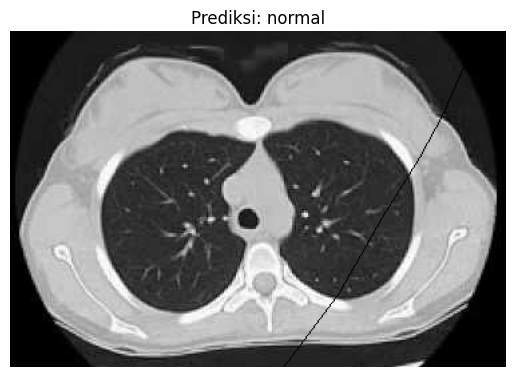

Gambar diklasifikasikan sebagai: normal


In [117]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from google.colab import drive

# Mount Google Drive untuk mengakses file model
drive.mount('/content/drive')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/paru/data/VGG19_model_best.h5"

# Muat model yang sudah dilatih
model = load_model(model_path)

# Fungsi untuk memproses gambar
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Daftar label kelas
class_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(img_path):
    img_array = prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Path ke gambar yang akan diuji
image_path = "/content/drive/MyDrive/paru/data/test/normal/10 (2) - Copy.png"

# Prediksi kelas gambar
predicted_label = predict_image_class(image_path)
print(f'Gambar diklasifikasikan sebagai: {predicted_label}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 0s 258ms/step


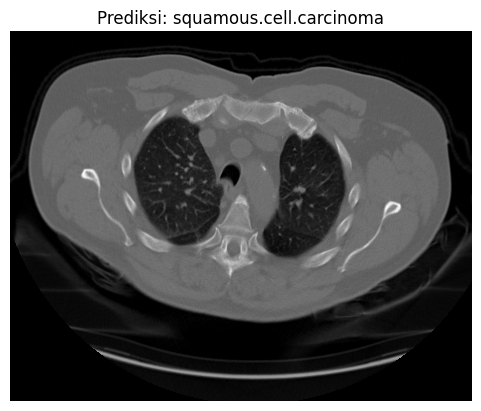

Gambar diklasifikasikan sebagai: squamous.cell.carcinoma


In [161]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from google.colab import drive

# Mount Google Drive untuk mengakses file model
drive.mount('/content/drive')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/paru/data/VGG19_model_best.h5"

# Muat model yang sudah dilatih
model = load_model(model_path)

# Fungsi untuk memproses gambar
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Daftar label kelas
class_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous.cell.carcinoma']

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(img_path):
    img_array = prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Path ke gambar yang akan diuji
image_path = "/content/drive/MyDrive/paru/data/test/squamous.cell.carcinoma/000177 (3).png"

# Prediksi kelas gambar
predicted_label = predict_image_class(image_path)
print(f'Gambar diklasifikasikan sebagai: {predicted_label}')